In [462]:
import numpy as np
from matplotlib import pyplot as plt

In [463]:
# return the homogenous form of vector x
# vector x must be series of 2D vectors
def h(x):
    if len(np.shape(x)) == 2 and np.shape(x)[0] == 2:
        return np.vstack([x, np.ones(np.shape(x)[1])])
    else:
        raise ValueError("Input to homogenous function must be series of 2D vectors")
    
# return the 2D form of homogenous vector h
# homogenous vector h must be series of 3D vectors
def f(h):
    if len(np.shape(h)) == 2 and np.shape(h)[0] == 3:
        return h[0:2,:]
    else:
        raise ValueError("Input to homogenous function must be series of 2D vectors")

In [464]:
class Mesh:
    def __init__(self, pts_x, pts_y, nds_x=None, nds_y=None):
        if len(pts_x) == len(pts_y):
            self.num_pts = len(pts_x)
            self.pts_x = pts_x
            self.pts_y = pts_y
            self.datums = np.array([pts_x, pts_y]) # hereafter, "a_i" is used to denote the [[x],[y]] position vector for the ith datum
            self.a = self.get_a() # hereafter, "a_ij" is used to denote the [[x],[y]] vector relating a_i to a_j
            self.Tp = np.zeros([self.num_pts, 3, 3])

        else:
            raise ValueError("Length of pts_x and pts_y must be the same.")
        
        if nds_x and nds_y:
            if len(nds_x) == len(nds_y):
                self.num_nds = len(nds_x)
                self.nds_x = nds_x
                self.nds_y = nds_y
                self.nodes = np.array([nds_x, nds_y]) # hereafter, "n_i" is used to denote the [[x],[y]] position vector for the ith node
                self.v = self.get_v() # hereafter, "v_ij" is used to denote the [[x],[y]] vector relating n_i to a_j
            else:
                raise ValueError("Length of nds_x and nds_y must be the same.")
            
        elif not (nds_x or nds_y):
            self.num_nds = 0
            self.nds_x = None
            self.nds_y = None
            self.nodes = None
            self.nd_vects = None

        else:
            raise ValueError("Incomplete input. Must pass both nds_x and nds_y if used.")
    
    
    def plot_rect(self, show_nodes=False):
        plt.scatter(x=self.pts_x, y=self.pts_y, s=50, marker='o')
        if show_nodes:
            plt.scatter(x=self.nodes[0], y=self.nodes[1], s=10, marker='D')
        plt.show()
    
    def get_a(self):
        # composite array of a_ij vectors, where a_ij = a_i - a_j
        a = np.zeros([self.num_pts, self.num_pts, 2])
        for i in range(self.num_pts):
            for j in range(self.num_pts):
                a[i,j,0] = self.pts_x[i] - self.pts_x[j] # x-component
                a[i,j,1] = self.pts_y[i] - self.pts_y[j] # y-component
        
        return a

    def get_v(self):
        # composite array of v_ij vectors, where v_ij = n_i - a_j
        v = np.zeros([self.num_nds, self.num_pts, 2])
        for i in range(self.num_nds):
            for j in range(self.num_pts):
                v[i,j,0] = self.nds_x[i] - self.pts_x[j] # x-component
                v[i,j,1] = self.nds_y[i] - self.pts_y[j] # y-component
        
        return v
    
    def get_T(self, img_datums):
        # composite array of transformation matrices T_i, defined by h(a)_i' = T_i * h(a)_i
        # where: "'"" (prime) denotes the image, and "h(x)" denotes the homogenous form of vector x
        Tp = np.zeros([self.num_pts, 3, 3])
        if img_datums is None:
            return Tp
        
        elif np.shape(self.datums) == np.shape(img_datums):
            for i in range(self.num_pts):
                Tp[i,0:3,0:3] = np.array([[1,0,img_datums[0,i]-self.datums[0,1]],
                                         [0,1,img_datums[1,i]-self.datums[1,1]],
                                         [0,0,1]
                                        ])
            return Tp
        
        else:
            raise ValueError("Shape of image does not match.")
    
    def get_theta(self):
        # composite array of theta_ij vectors, where theta_ij = (arithmetic average of T_k * v_ij)
        theta = np.zeros([self.num_nds, self.num_pts, 2])
        for i in range(self.num_nds):
            for j in range(self.num_pts):
                sum = np.zeros([2,1])
                for k in range(self.num_pts):
                    v_ij = self.v[i,j,:]
                    v_ij = v_ij[:,None] # create column vector from np slice
                    T_k = self.Tp[k]
                    sum += f(np.matmul(T_k, h(v_ij)))
                
                avg = (1/self.num_pts) * sum
                theta[i,j,:] = avg.ravel()
        
        return theta

    def fill_nds(self):
        pass

In [465]:
# Define origination mesh
pts_x = [0,2,2,0]
pts_y = [0,0,2,2]
nds_x = [0,2,2,0,1,2,1,0]
nds_y = [0,0,2,2,0,1,2,1]
orig_mesh = Mesh(pts_x, pts_y, nds_x, nds_y)

In [466]:
# # confirm functionality of v_ij composite array
# print(orig_mesh.v)

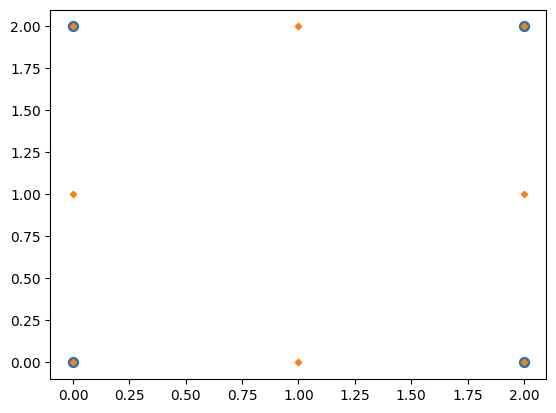

In [467]:
# Plot origination mesh
orig_mesh.plot_rect(show_nodes=True)

In [468]:
# Define image mesh (datums only)
img_pts_x = [0,4,4,0]
img_pts_y = [0,0,4,4]
img_mesh = Mesh(img_pts_x, img_pts_y)

In [469]:
# generate transformation matrices
orig_mesh.Tp = orig_mesh.get_T(img_mesh.datums)
# print("T array:\n", orig_mesh.Tp)


In [470]:
# # confirm functionality homogenous function
# h_datums = h(orig_mesh.datums)
# print("h datums:\n", h_datums)
# print()

# # confirm functionality of anti-homogenous function
# f_datums = f(h_datums)
# print("f datums:\n", f_datums)

In [471]:
# demo theta calculation
print(orig_mesh.get_theta())

[[[ 0.  2.]
  [-2.  2.]
  [-2.  0.]
  [ 0.  0.]]

 [[ 2.  2.]
  [ 0.  2.]
  [ 0.  0.]
  [ 2.  0.]]

 [[ 2.  4.]
  [ 0.  4.]
  [ 0.  2.]
  [ 2.  2.]]

 [[ 0.  4.]
  [-2.  4.]
  [-2.  2.]
  [ 0.  2.]]

 [[ 1.  2.]
  [-1.  2.]
  [-1.  0.]
  [ 1.  0.]]

 [[ 2.  3.]
  [ 0.  3.]
  [ 0.  1.]
  [ 2.  1.]]

 [[ 1.  4.]
  [-1.  4.]
  [-1.  2.]
  [ 1.  2.]]

 [[ 0.  3.]
  [-2.  3.]
  [-2.  1.]
  [ 0.  1.]]]


In [472]:
# Morph midside nodes to destination rectangle

In [473]:
# Example with dissimilar rectangles

In [474]:
# Example with more than one midside node